<h1>Thêm thư viện cần thiết

In [1]:
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.utils import column_or_1d

warnings.filterwarnings('ignore')


<h1>Nạp dữ liệu

In [2]:
df_train = pd.read_csv("../../../Dataset/xrp_train_7_3.csv", parse_dates=True,
                       index_col=0).drop(columns=['Close', 'High', 'Low', 'Volume', 'Currency'])
df_index_train = df_train.index
df_train.head()


,Open
Date,
2020-06-01,0.20254
2020-06-02,0.21090
2020-06-03,0.20316
2020-06-04,0.20411
2020-06-05,0.20438


In [3]:
df_test = pd.read_csv("../../../Dataset/xrp_test_7_3.csv", parse_dates=True,
                      index_col=0).drop(columns=['Close', 'High', 'Low', 'Volume', 'Currency'])
df_index_test = df_test.index
df_test.head()


,Open
Date,
2021-10-26,1.09527
2021-10-27,1.10671
2021-10-28,0.99358
2021-10-29,1.05806
2021-10-30,1.08107


# Tạo mới cột Timestamp để dự báo theo chuỗi thời gian

In [4]:
df_train['Timestamp'] = pd.to_datetime(df_train.index).astype(np.int64) / 10**9
df_train.head()


,Open,Timestamp
Date,,
2020-06-01,0.20254,1.590970e+09
2020-06-02,0.21090,1.591056e+09
2020-06-03,0.20316,1.591142e+09
2020-06-04,0.20411,1.591229e+09
2020-06-05,0.20438,1.591315e+09


In [5]:
df_test['Timestamp'] = pd.to_datetime(df_test.index).astype(np.int64) / 10**9
df_test.head()


,Open,Timestamp
Date,,
2021-10-26,1.09527,1.635206e+09
2021-10-27,1.10671,1.635293e+09
2021-10-28,0.99358,1.635379e+09
2021-10-29,1.05806,1.635466e+09
2021-10-30,1.08107,1.635552e+09


# Vẽ đồ thị

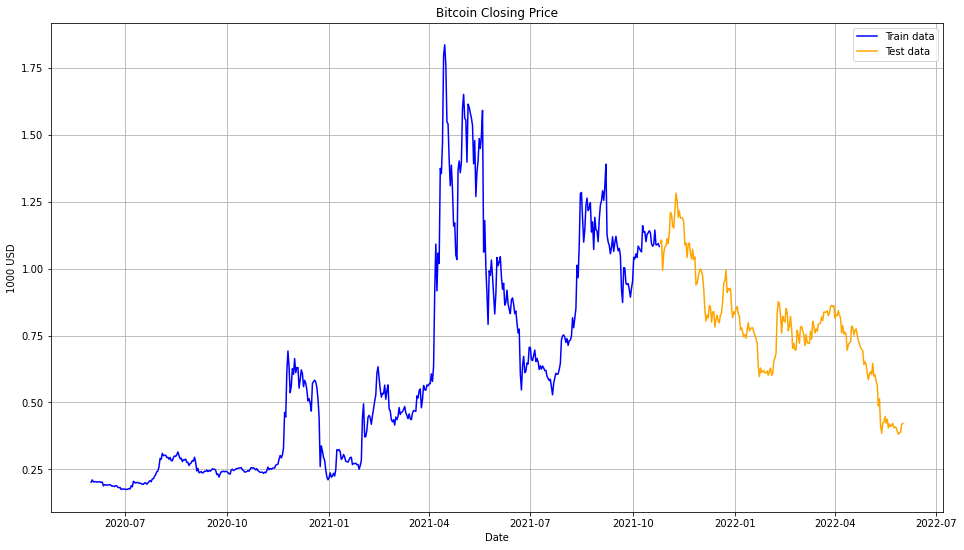

In [6]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.title("Bitcoin Closing Price")
plt.xlabel('Date')
plt.ylabel('1000 USD')
plt.plot(df_train['Open'], 'blue', label='Train data')
plt.plot(df_test['Open'], 'orange', label='Test data')
plt.legend()


# Thực hiện xây dựng mô hình SVR

## Cần chuẩn hóa dữ liệu để thuận tiện cho việc xây dựng mô hình

In [7]:
X_sc_train = StandardScaler()
y_sc_train = StandardScaler()

x_train = df_train.iloc[:, 1].values.reshape(-1, 1)
y_train = df_train.iloc[:, 0].values.reshape(-1, 1)


X_scaled_train = X_sc_train.fit_transform(x_train)
y_scaled_train = y_sc_train.fit_transform(y_train)


df_scaled_train = pd.DataFrame(index=df_index_train)
df_scaled_train['Timestamp'] = X_scaled_train
df_scaled_train['Open'] = y_scaled_train
df_scaled_train.head()


,Timestamp,Open
Date,,
2020-06-01,-1.728671,-1.008335
2020-06-02,-1.721905,-0.987501
2020-06-03,-1.715140,-1.006790
2020-06-04,-1.708374,-1.004422
2020-06-05,-1.701608,-1.003750


In [8]:
X_sc_test = StandardScaler()
y_sc_test = StandardScaler()

x_test = df_test.iloc[:, 1].values.reshape(-1, 1)
y_test = df_test.iloc[:, 0].values.reshape(-1, 1)


X_scaled_test = X_sc_test.fit_transform(x_test)
y_scaled_test = y_sc_test.fit_transform(y_test)


df_scaled_test = pd.DataFrame(index=df_index_test)
df_scaled_test['Timestamp'] = X_scaled_test
df_scaled_test['Open'] = y_scaled_test
df_scaled_test.head()


,Timestamp,Open
Date,,
2021-10-26,-1.724160,1.562080
2021-10-27,-1.708342,1.620022
2021-10-28,-1.692524,1.047041
2021-10-29,-1.676706,1.373619
2021-10-30,-1.660888,1.490160


# Xác định biến độc lập (X) và biến phụ thuộc (y)

In [9]:
X_train = df_scaled_train['Timestamp'].values.reshape(-1, 1)
y_train = df_scaled_train['Open'].values.reshape(-1, 1)

X_test = df_scaled_test['Timestamp'].values.reshape(-1, 1)
y_test = df_scaled_test['Open'].values.reshape(-1, 1)


## Hàm tạo hyperparameters

In [10]:
def para_range(minimum, maximum, step):
    para_list = np.arange(minimum, maximum, step)
    return para_list


# Hàm xuất kết quả của từng trường hợp trong GridSearch

In [11]:
def print_stats(hyperparams, stats):
    if(hyperparams[0] == 'poly'):
        print(
            f'SVR(kernel={hyperparams[0]}, C={hyperparams[1]}, gamma={hyperparams[2]}, degree={hyperparams[3]}')
    else:
        print(
            f'SVR(kernel={hyperparams[0]}, C={hyperparams[1]}, gamma={hyperparams[2]}')

    print(
        f"MAE={stats[0]:.2f} | MAPE={stats[1]:.2f} | MSE={stats[2] :.2f} | RMSE={stats[3]:.2f}")


# Tạo các giá trị cho các hyperparameters

In [12]:
kernels = ['sigmoid', 'rbf', 'poly']
Cs = para_range(0.01, 0.2, 0.1)
gammas = para_range(0.1, 5, 0.1)
degrees = para_range(1, 6, 1)


## GridSearch để tìm hyperparameters phù hợp

In [13]:
warnings.filterwarnings('ignore')

stats_df = pd.DataFrame(
    columns=['kernel', 'C', 'gamma', 'degree', 'MAE', 'MAPE', 'MSE', 'RMSE'])

# Sử dụng gird-seach để tìm hyperparameters phù hợp
for ker in kernels:
    # Nếu kernel == poly thì thực hiện chọn degree
    if(ker != 'poly'):
        for C in Cs:
            for gamma in gammas:
                rgs = SVR(kernel=ker, C=C, gamma=gamma, verbose=False)
                rgs.fit(X_train, y_train)
                pred = rgs.predict(X_test)

                # Đảo tỷ lệ thành giá trị thực
                inv_pred = y_sc_test.inverse_transform(
                    column_or_1d(pred).reshape(-1, 1))
                inv_test = y_sc_test.inverse_transform(
                    column_or_1d(y_test).reshape(-1, 1))
                    
                # Đánh giá mô hình
                mae = mean_absolute_error(inv_test, inv_pred)
                mape = mean_absolute_percentage_error(inv_test, inv_pred)
                mse = mean_squared_error(inv_test, inv_pred)
                rmse = np.sqrt(mse)

                result = {'kernel': ker, 'C': C, 'gamma': gamma, 'degree': 0,
                          'MAE': mae, 'MAPE': mape, 'MSE': mse, 'RMSE': rmse}

                hyperparam = [ker, C, gamma, 0]
                stats = [mae, mape, mse, rmse]
                stats_df = stats_df.append(result, ignore_index=True)
                print_stats(hyperparam, stats)
    else:
        for C in Cs:
            for gamma in gammas:
                for deg in degrees:
                    rgs = SVR(kernel=ker, C=C, gamma=gamma, degree=deg, verbose=False)
                    rgs.fit(X_train, y_train.reshape(-1, 1))
                    pred = rgs.predict(X_test)

                    # Đảo tỷ lệ thành giá trị thực
                    inv_pred = y_sc_test.inverse_transform(
                        column_or_1d(pred).reshape(-1, 1))
                    inv_test = y_sc_test.inverse_transform(
                        column_or_1d(y_test).reshape(-1, 1))

                    # Đánh giá mô hình
                    mae = mean_absolute_error(inv_test, inv_pred)
                    mape = mean_absolute_percentage_error(inv_test, inv_pred)
                    mse = mean_squared_error(inv_test, inv_pred)
                    rmse = np.sqrt(mse)

                    result = {'kernel': ker, 'C': C, 'gamma': gamma, 'degree': deg,
                            'MAE': mae, 'MAPE': mape, 'MSE': mse, 'RMSE': rmse}

                    hyperparam = [ker, C, gamma, deg]
                    stats = [mae, mape, mse, rmse]

                    stats_df = stats_df.append(result, ignore_index=True)

                    print_stats(hyperparam, stats)


SVR(kernel=sigmoid, C=0.01, gamma=0.1
MAE=0.20 | MAPE=0.27 | MSE=0.07 | RMSE=0.26
SVR(kernel=sigmoid, C=0.01, gamma=0.2
MAE=0.21 | MAPE=0.29 | MSE=0.08 | RMSE=0.28
SVR(kernel=sigmoid, C=0.01, gamma=0.30000000000000004
MAE=0.22 | MAPE=0.30 | MSE=0.08 | RMSE=0.29
SVR(kernel=sigmoid, C=0.01, gamma=0.4
MAE=0.22 | MAPE=0.31 | MSE=0.08 | RMSE=0.29
SVR(kernel=sigmoid, C=0.01, gamma=0.5
MAE=0.22 | MAPE=0.31 | MSE=0.09 | RMSE=0.29
SVR(kernel=sigmoid, C=0.01, gamma=0.6
MAE=0.22 | MAPE=0.32 | MSE=0.09 | RMSE=0.29
SVR(kernel=sigmoid, C=0.01, gamma=0.7000000000000001
MAE=0.23 | MAPE=0.32 | MSE=0.09 | RMSE=0.30
SVR(kernel=sigmoid, C=0.01, gamma=0.8
MAE=0.23 | MAPE=0.33 | MSE=0.09 | RMSE=0.30
SVR(kernel=sigmoid, C=0.01, gamma=0.9
MAE=0.23 | MAPE=0.33 | MSE=0.09 | RMSE=0.30
SVR(kernel=sigmoid, C=0.01, gamma=1.0
MAE=0.24 | MAPE=0.33 | MSE=0.09 | RMSE=0.30
SVR(kernel=sigmoid, C=0.01, gamma=1.1
MAE=0.24 | MAPE=0.33 | MSE=0.09 | RMSE=0.30
SVR(kernel=sigmoid, C=0.01, gamma=1.2000000000000002
MAE=0.24 | MAP

In [14]:
best_fit_model = stats_df[stats_df['MAPE']
                          == stats_df['MAPE'].min()].head(1)
best_fit_model


,kernel,C,gamma,degree,MAE,MAPE,MSE,RMSE
199,poly,0.01,0.1,4,0.153186,0.211832,0.041461,0.20362


In [15]:
kernel = str(best_fit_model['kernel'].values[0])
C = float(best_fit_model['C'])
gamma = float(best_fit_model['gamma'])
degree = int(best_fit_model['degree'])

if(kernel == 'poly'):
    rgs = SVR(kernel=kernel, C=C, gamma=gamma, degree=degree)
else:
    rgs = SVR(kernel=kernel, C=C, gamma=gamma)
    
rgs.fit(X_train, y_train.reshape(-1, 1))
pred = rgs.predict(X_test)
pred

array([-0.2521174 , -0.25211767, -0.25211793, -0.25211818, -0.25211842,
       -0.25211866, -0.25211889, -0.25211911, -0.25211933, -0.25211954,
       -0.25211975, -0.25211995, -0.25212014, -0.25212033, -0.25212051,
       -0.25212068, -0.25212085, -0.25212102, -0.25212118, -0.25212133,
       -0.25212148, -0.25212163, -0.25212177, -0.2521219 , -0.25212203,
       -0.25212216, -0.25212228, -0.25212239, -0.25212251, -0.25212262,
       -0.25212272, -0.25212282, -0.25212292, -0.25212301, -0.2521231 ,
       -0.25212319, -0.25212327, -0.25212335, -0.25212343, -0.2521235 ,
       -0.25212357, -0.25212363, -0.2521237 , -0.25212376, -0.25212382,
       -0.25212387, -0.25212393, -0.25212398, -0.25212403, -0.25212407,
       -0.25212412, -0.25212416, -0.2521242 , -0.25212424, -0.25212427,
       -0.25212431, -0.25212434, -0.25212437, -0.2521244 , -0.25212442,
       -0.25212445, -0.25212447, -0.25212449, -0.25212451, -0.25212453,
       -0.25212455, -0.25212457, -0.25212459, -0.2521246 , -0.25

<h1>Đưa dữ liệu về miền giá trị ban đầu

In [16]:
inv_pred = y_sc_test.inverse_transform(
    column_or_1d(pred).reshape(-1, 1))
inv_test = y_sc_test.inverse_transform(
    column_or_1d(y_test).reshape(-1, 1))


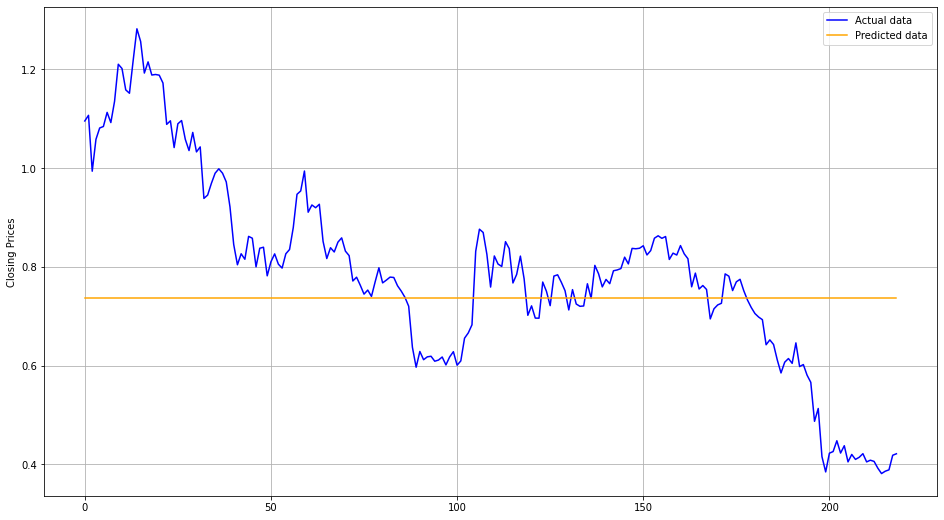

In [17]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Closing Prices')
plt.plot(column_or_1d(inv_test), 'blue', label='Actual data')
plt.plot(column_or_1d(inv_pred), 'orange', label='Predicted data')
plt.legend()


# Đánh giá mô hình

In [18]:
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_test, inv_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"R2: {r2:.2f}")


RMSE: 0.20
MAPE: 21.18%
R2: -0.06
